In [6]:
import torch
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import random

sys.path.insert(0, os.path.abspath('../../'))
from DNN_module import Net

# CPU
torch.set_default_device("cpu")

%run ../../NCoinDP_functions.ipynb

In [7]:
import torch

# Number of data points
#S = 500

# time inteval
delta = 1/12

#n = int(S/delta)
n = 1000

# Observation time
obtime = np.arange(0,n+1)/n * n * delta
print(len(obtime))

sim = 0

1001


In [8]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu"
device = torch.device(dev)

2.1.2+cu121
True
NVIDIA A100 80GB PCIe


In [9]:
beta_range = [-0.5, 0.5]
sigma2_range = [0.1, 1]

lamb_p_range = [0.1, 1]
lamb_n_range = [0.1, 1]

eta_p_range = [0.1, 1]
eta_n_range = [0.1, 1]

In [10]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from DNN_module import Net
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

# Default : cuda
torch.set_default_device('cuda')

# Define the batch size
BATCH_SIZE = 64

# Number of Epochs
N_EPOCHS = 350
    
# Number of Simulations
sims = 10

# Number of observation
#nums = [500, 1000, 3000]

for sim in range(0, 4):
        # Data import
        sim_path = "../../../depot_hyun/hyun/PBJD/PBJD_sim" + str(sim) + "_" + str(n)+ ".pt"
        [X_raw, output] = torch.load(sim_path)
        X_raw = X_raw.to("cpu")
        
        c_tmp = torch.quantile(X_raw, torch.tensor([.0001,.9999], device = "cpu"), 0)
        a = torch.reshape(c_tmp[0], (1, c_tmp.size()[1]))
        b = torch.reshape(c_tmp[1], (1, c_tmp.size()[1]))

        X = torch.clone((X_raw - a) / (b - a))
        
        scale_path = "PBJD_sim/PBJD_scale/PBJD_scale" + str(sim) + "_" + str(n)+ ".pt"
        torch.save([a,b], scale_path)

        X = X.to(device)
        output = output.to(device)
        
        L = X.size()[0]
        Lval = 40000
        Ltest = 10000
        

        X_train = X[range(0,L-Lval-Ltest),:]
        y_train = output[range(0,L-Lval-Ltest),:]

        X_val = X[range(L-Lval-Ltest,L-Ltest),:]
        y_val = output[range(L-Lval-Ltest,L-Ltest),:]

        X_test = X[range(L-Ltest,L),:]
        y_test = output[range(L-Ltest,L),:]

        print(X_train.size(), X_val.size(),X_test.size())
        
        
        # Use torch.utils.data to create a DataLoader that will take care of creating batches
        dataset = TensorDataset(X_train, y_train)
        dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True, generator=torch.Generator(device=device))

        # Get the dataset size for printing (it is equal to N_SAMPLES)
        dataset_size = len(dataloader.dataset)
        
        # Define the input and output dimensions
        D_in, H, H2, H3, D_out = X_train.size()[1], 512, 512, 512, y_train.size()[1]

        # Create an instance of the Net class with specified dimensions
        torch.manual_seed(2725)
        net = Net(D_in, D_out, H = H, H2 = H2, H3 = H3)

        # Model name
        model_save_name = 'PBJD_nets/PBJD_' + str(sim) + "_" + str(n)+ ".pt"
        path = F"./{model_save_name}"

        # The nn package also contains definitions of popular loss functions; in this case we will use Mean Squared Error (MSE) as our loss function.
        def weighted_mse_loss(input, target, weight):
            return (weight * (input - target) ** 2).sum()
    
        out_range = [torch.quantile(y_train,.01, 0).detach().cpu().numpy(), 
                     torch.quantile(y_train,.99, 0).detach().cpu().numpy()]
        weight_1 = torch.tensor(1/(out_range[1] - out_range[0])**2)

        learning_rate = 1e-5
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)

        train_error_plt = []
        val_error_plt = []

        torch.manual_seed(2000 + sim)
        
        # Loop over epochs
        file = open("log/PBJD_sim.txt","a")
        file.write(sim_path + "start" + "sim: " + str(sim)+ "\n")
        file.close()
        
        # Loop over epochs
        for epoch in range(N_EPOCHS):
            for id_batch, (x_batch, y_batch) in enumerate(dataloader):
                y_batch_pred = net(x_batch)
                loss = weighted_mse_loss(y_batch, y_batch_pred, weight_1)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if epoch % 50 ==0 and id_batch % 100 == 0:
                    loss, current = loss.item(), (id_batch + 1)* len(x_batch)
                    print(f"train_loss: {loss/BATCH_SIZE:>7f}  [{current:>5d}/{dataset_size:>5d}]")

            with torch.no_grad():
                net.eval()
                theta_pred_train = net(X_train)
                train_loss = weighted_mse_loss(y_train, theta_pred_train, weight_1) / (L-Lval-Ltest)
                train_error_plt.append(train_loss.to("cpu"))

                theta_pred_val = net(X_val)
                val_loss = weighted_mse_loss(y_val, theta_pred_val, weight_1) / Lval
                val_error_plt.append(val_loss.to("cpu"))

            if epoch % 10 ==0:
                print(f"Epoch {epoch + 1}\n-------------------------------")
                print(f"train_loss {train_loss:>7f} val_loss {val_loss:>7f}")
                print("learning rate: ", learning_rate, "sim: ", sim)

            # Choose Best Model
            if val_error_plt[epoch] == np.min(val_error_plt):
                best=epoch
                torch.save(net.state_dict(), path)

            if epoch % 100 ==99:
                net.load_state_dict(torch.load(path))
                learning_rate = max(learning_rate * 1e-1, 1e-9)
            print(min(val_error_plt))
            
            
        file = open("log/PBJD_sim.txt","a")
        file.write(sim_path + "end" + "sim: " + str(sim)+ "\n")
        file.close()
        

torch.Size([200000, 90]) torch.Size([40000, 90]) torch.Size([10000, 90])
train_loss: 2.654720  [   64/200000]
train_loss: 0.802080  [ 6464/200000]
train_loss: 0.415037  [12864/200000]
train_loss: 0.252918  [19264/200000]
train_loss: 0.206441  [25664/200000]
train_loss: 0.179571  [32064/200000]
train_loss: 0.159518  [38464/200000]
train_loss: 0.156899  [44864/200000]
train_loss: 0.162134  [51264/200000]
train_loss: 0.149851  [57664/200000]
train_loss: 0.131538  [64064/200000]
train_loss: 0.146674  [70464/200000]
train_loss: 0.153707  [76864/200000]
train_loss: 0.132547  [83264/200000]
train_loss: 0.124933  [89664/200000]
train_loss: 0.144201  [96064/200000]
train_loss: 0.124583  [102464/200000]
train_loss: 0.123652  [108864/200000]
train_loss: 0.112858  [115264/200000]
train_loss: 0.111981  [121664/200000]
train_loss: 0.105013  [128064/200000]
train_loss: 0.109713  [134464/200000]
train_loss: 0.107698  [140864/200000]
train_loss: 0.098210  [147264/200000]
train_loss: 0.113702  [153664/2

train_loss: 0.051785  [89664/200000]
train_loss: 0.059917  [96064/200000]
train_loss: 0.045414  [102464/200000]
train_loss: 0.052293  [108864/200000]
train_loss: 0.056481  [115264/200000]
train_loss: 0.042878  [121664/200000]
train_loss: 0.052810  [128064/200000]
train_loss: 0.060638  [134464/200000]
train_loss: 0.053830  [140864/200000]
train_loss: 0.056919  [147264/200000]
train_loss: 0.054303  [153664/200000]
train_loss: 0.045732  [160064/200000]
train_loss: 0.050121  [166464/200000]
train_loss: 0.057664  [172864/200000]
train_loss: 0.051244  [179264/200000]
train_loss: 0.053966  [185664/200000]
train_loss: 0.061107  [192064/200000]
train_loss: 0.042584  [198464/200000]
Epoch 151
-------------------------------
train_loss 0.052542 val_loss 0.062584
learning rate:  1.0000000000000002e-06 sim:  0
tensor(0.0616)
tensor(0.0616)
tensor(0.0616)
tensor(0.0616)
tensor(0.0616)
tensor(0.0616)
tensor(0.0616)
tensor(0.0616)
tensor(0.0616)
tensor(0.0616)
Epoch 161
-------------------------------

train_loss: 0.046094  [166464/200000]
train_loss: 0.056246  [172864/200000]
train_loss: 0.044202  [179264/200000]
train_loss: 0.060246  [185664/200000]
train_loss: 0.053625  [192064/200000]
train_loss: 0.063330  [198464/200000]
Epoch 301
-------------------------------
train_loss 0.055650 val_loss 0.063498
learning rate:  1.0000000000000004e-08 sim:  0
tensor(0.0616)
tensor(0.0616)
tensor(0.0616)
tensor(0.0616)
tensor(0.0616)
tensor(0.0616)
tensor(0.0616)
tensor(0.0616)
tensor(0.0616)
tensor(0.0616)
Epoch 311
-------------------------------
train_loss 0.054573 val_loss 0.062042
learning rate:  1.0000000000000004e-08 sim:  0
tensor(0.0616)
tensor(0.0616)
tensor(0.0616)
tensor(0.0616)
tensor(0.0616)
tensor(0.0616)
tensor(0.0616)
tensor(0.0616)
tensor(0.0616)
tensor(0.0616)
Epoch 321
-------------------------------
train_loss 0.053929 val_loss 0.062044
learning rate:  1.0000000000000004e-08 sim:  0
tensor(0.0616)
tensor(0.0616)
tensor(0.0616)
tensor(0.0616)
tensor(0.0616)
tensor(0.0616)
t

tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
Epoch 121
-------------------------------
train_loss 0.056969 val_loss 0.063143
learning rate:  1.0000000000000002e-06 sim:  1
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
Epoch 131
-------------------------------
train_loss 0.053276 val_loss 0.061621
learning rate:  1.0000000000000002e-06 sim:  1
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
Epoch 141
-------------------------------
train_loss 0.053033 val_loss 0.061945
learning rate:  1.0000000000000002e-06 sim:  1
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
train_loss: 0.048516  [   64/20000

tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
Epoch 291
-------------------------------
train_loss 0.050840 val_loss 0.063333
learning rate:  1.0000000000000002e-07 sim:  1
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
tensor(0.0612)
train_loss: 0.039429  [   64/200000]
train_loss: 0.061553  [ 6464/200000]
train_loss: 0.059539  [12864/200000]
train_loss: 0.048606  [19264/200000]
train_loss: 0.063941  [25664/200000]
train_loss: 0.047108  [32064/200000]
train_loss: 0.056458  [38464/200000]
train_loss: 0.059294  [44864/200000]
train_loss: 0.047985  [51264/200000]
train_loss: 0.053137  [57664/200000]
train_loss: 0.058885  [64064/200000]
train_loss: 0.055126  [70464/200000]
train_loss: 0.045650  [76864/200000]
train_loss: 0.053964  [83264/200000]
train_loss: 0.055600  [89664/200000]
train_loss: 0.047273  [96064/2000

train_loss: 0.049150  [12864/200000]
train_loss: 0.055982  [19264/200000]
train_loss: 0.056798  [25664/200000]
train_loss: 0.049756  [32064/200000]
train_loss: 0.052938  [38464/200000]
train_loss: 0.049140  [44864/200000]
train_loss: 0.055772  [51264/200000]
train_loss: 0.047879  [57664/200000]
train_loss: 0.049778  [64064/200000]
train_loss: 0.052061  [70464/200000]
train_loss: 0.059886  [76864/200000]
train_loss: 0.063284  [83264/200000]
train_loss: 0.054465  [89664/200000]
train_loss: 0.053883  [96064/200000]
train_loss: 0.060689  [102464/200000]
train_loss: 0.053710  [108864/200000]
train_loss: 0.053230  [115264/200000]
train_loss: 0.056862  [121664/200000]
train_loss: 0.052683  [128064/200000]
train_loss: 0.067778  [134464/200000]
train_loss: 0.057743  [140864/200000]
train_loss: 0.050317  [147264/200000]
train_loss: 0.057472  [153664/200000]
train_loss: 0.055313  [160064/200000]
train_loss: 0.047516  [166464/200000]
train_loss: 0.063140  [172864/200000]
train_loss: 0.056762  [179

train_loss: 0.044725  [89664/200000]
train_loss: 0.050488  [96064/200000]
train_loss: 0.053428  [102464/200000]
train_loss: 0.053028  [108864/200000]
train_loss: 0.048594  [115264/200000]
train_loss: 0.046283  [121664/200000]
train_loss: 0.059548  [128064/200000]
train_loss: 0.052104  [134464/200000]
train_loss: 0.055587  [140864/200000]
train_loss: 0.059521  [147264/200000]
train_loss: 0.042677  [153664/200000]
train_loss: 0.061358  [160064/200000]
train_loss: 0.048254  [166464/200000]
train_loss: 0.056356  [172864/200000]
train_loss: 0.057164  [179264/200000]
train_loss: 0.052962  [185664/200000]
train_loss: 0.053000  [192064/200000]
train_loss: 0.052062  [198464/200000]
Epoch 251
-------------------------------
train_loss 0.068350 val_loss 0.090228
learning rate:  1.0000000000000002e-07 sim:  2
tensor(0.0614)
tensor(0.0614)
tensor(0.0614)
tensor(0.0614)
tensor(0.0614)
tensor(0.0614)
tensor(0.0614)
tensor(0.0614)
tensor(0.0614)
tensor(0.0614)
Epoch 261
-------------------------------

train_loss: 0.051251  [172864/200000]
train_loss: 0.054507  [179264/200000]
train_loss: 0.056505  [185664/200000]
train_loss: 0.054687  [192064/200000]
train_loss: 0.058298  [198464/200000]
Epoch 51
-------------------------------
train_loss 0.058768 val_loss 0.059960
learning rate:  1e-05 sim:  3
tensor(0.0597)
tensor(0.0597)
tensor(0.0597)
tensor(0.0597)
tensor(0.0597)
tensor(0.0596)
tensor(0.0596)
tensor(0.0596)
tensor(0.0596)
tensor(0.0596)
Epoch 61
-------------------------------
train_loss 0.059998 val_loss 0.061312
learning rate:  1e-05 sim:  3
tensor(0.0596)
tensor(0.0596)
tensor(0.0596)
tensor(0.0596)
tensor(0.0596)
tensor(0.0596)
tensor(0.0596)
tensor(0.0596)
tensor(0.0595)
tensor(0.0593)
Epoch 71
-------------------------------
train_loss 0.057845 val_loss 0.059215
learning rate:  1e-05 sim:  3
tensor(0.0592)
tensor(0.0592)
tensor(0.0592)
tensor(0.0592)
tensor(0.0592)
tensor(0.0592)
tensor(0.0592)
tensor(0.0592)
tensor(0.0592)
tensor(0.0592)
Epoch 81
------------------------

tensor(0.0588)
tensor(0.0588)
tensor(0.0588)
tensor(0.0588)
tensor(0.0588)
tensor(0.0588)
tensor(0.0588)
tensor(0.0588)
tensor(0.0588)
Epoch 221
-------------------------------
train_loss 0.057061 val_loss 0.059386
learning rate:  1.0000000000000002e-07 sim:  3
tensor(0.0588)
tensor(0.0588)
tensor(0.0588)
tensor(0.0588)
tensor(0.0588)
tensor(0.0588)
tensor(0.0588)
tensor(0.0588)
tensor(0.0588)
tensor(0.0588)
Epoch 231
-------------------------------
train_loss 0.056460 val_loss 0.058907
learning rate:  1.0000000000000002e-07 sim:  3
tensor(0.0588)
tensor(0.0588)
tensor(0.0588)
tensor(0.0588)
tensor(0.0588)
tensor(0.0588)
tensor(0.0588)
tensor(0.0588)
tensor(0.0588)
tensor(0.0588)
Epoch 241
-------------------------------
train_loss 0.056542 val_loss 0.059067
learning rate:  1.0000000000000002e-07 sim:  3
tensor(0.0588)
tensor(0.0588)
tensor(0.0588)
tensor(0.0588)
tensor(0.0588)
tensor(0.0588)
tensor(0.0588)
tensor(0.0588)
tensor(0.0588)
tensor(0.0588)
train_loss: 0.065317  [   64/20000

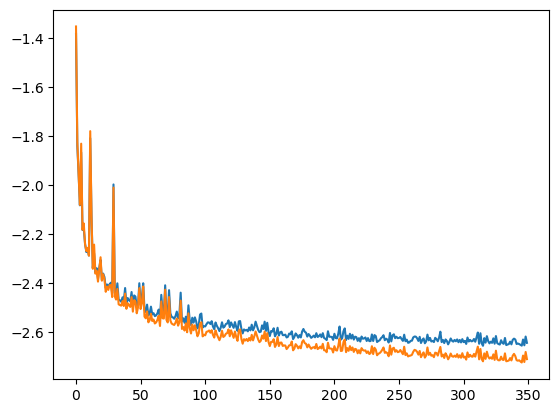

In [29]:
plt.plot(range(N_EPOCHS), np.log(val_error_plt))
plt.plot(range(N_EPOCHS), np.log(train_error_plt))
torch.save([val_error_plt, train_error_plt], "PBJD_plots/PBJD_error_plt_baselines.pt")

0.07016173


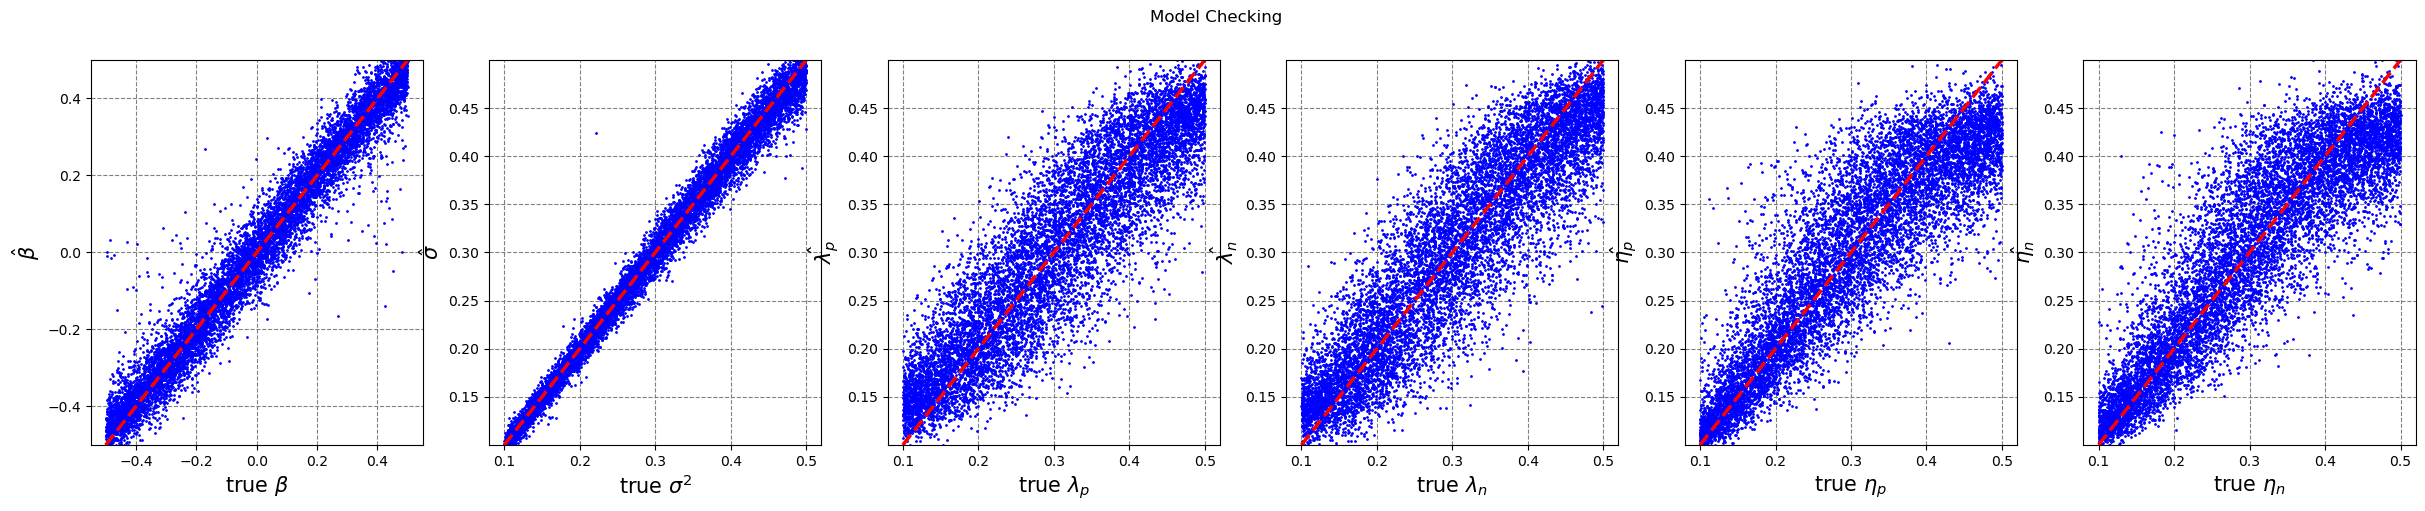

In [30]:
net.load_state_dict(torch.load(path))
print(np.min(val_error_plt))
net.eval()
torch.set_default_device("cpu")

net = net.to("cpu")
X_test = X_test.to("cpu")
y_test = y_test.to("cpu")

true_name = [r'true $\beta$', r'true $\sigma^2$', r'true $\lambda_p$', r'true $\lambda_n$', r'true $\eta_p$', r'true $\eta_n$']
#true_name = [r'true $\kappa$', r'true $\beta$', r'true $\lambda$', r'true $\mu$']

esti_name = [r'$\hat{\beta}$', r'$\hat{\sigma}$', r'$\hat{\lambda_p}$', r'$\hat{\lambda_n}$', r'$\hat{\eta_p}$', r'$\hat{\eta_n}$']
#esti_name = [r'$\hat{\kappa}$', r'$\hat{\beta}$', r'$\hat{\lambda}$', r'$\hat{\mu}$']


with torch.no_grad():
    net.eval()
    tmp = net(X_test)
    tmp = tmp.detach().cpu().numpy()

## Plot for model checking

lim_left = torch.min(output,0).values.detach().cpu().numpy()
lim_right = torch.max(output,0).values.detach().cpu().numpy()


fig, axes = plt.subplots(1, len(tmp[0]), figsize=(30,5))
fig.suptitle('Model Checking')

for i in range(len(tmp[0])):
    lim0 = lim_left[i]
    lim1 = lim_right[i]
    
    tmp1 = tmp[:, i]
    axes[i].scatter(y_test[:,i], tmp1, marker='o', color='b', s= 1)
    axes[i].set_xlabel(true_name[i], fontsize=15)
    axes[i].set_ylabel(esti_name[i], fontsize=15)
    axes[i].plot(np.linspace(lim0, lim1, 1000), np.linspace(lim0, lim1, 1000), color = "red", linestyle='dashed', linewidth = 2.5)
    axes[i].set_axisbelow(True)
    axes[i].grid(color='gray', linestyle='dashed')
    axes[i].set_ylim([lim0, lim1])

plt.show()